In [1]:
import numpy as np
import cv2
import time
from feature_tracker import FeatureTrackerTypes, FeatureTracker, FeatureTrackingResult
from feature_orb2D import OrbFeature2D
from feature_matcher import feature_matcher_factory, FeatureMatcherTypes
from parameters import Parameters 
import random
import tracemalloc
import linecache
from visual_odometry import ImageRecievedState, VisualOdometry
from camera import KinectCamera
from utils import compute_euler_angle
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
MinNumFeatureDefault = Parameters.MinNumFeatureDefault
RatioTest = Parameters.FeatureMatchRatioTest
gt_t = np.load("D:/Others/Projects/VO-SLAM/101/0/translations.npy")
gt_r = np.load("D:/Others/Projects/VO-SLAM/101/0/rotationsM.npy")
depth = np.load("D:/Others/Projects/VO-SLAM/101/0/depth.npy")

width  = 640
height = 480
fx     = 554.254691191187
fy     = 554.254691191187
cx     = 320.5
cy     = 240.5
D      = [0.0, 0.0, 0.0, 0.0, 0.0] 

cam = KinectCamera(width, height, fx, fy, cx, cy, D)

feature_tracker = FeatureTracker(num_features=MinNumFeatureDefault, 
                       num_levels = 8,  
                       scale_factor = 1.2,   
                       match_ratio_test = RatioTest, 
                       tracker_type = FeatureTrackerTypes.DES_BF)

Using Orb Feature 2D


In [3]:
vo = VisualOdometry(cam, feature_tracker, True, True)

In [10]:
start = time.time()
for i in range(500):
    path = "D:/Others/Projects/VO-SLAM/101/image_"+str(i)+".jpg"
    img = cv2.imread(path)
    vo.trackImage(img, depth[i], gt_t[i], gt_r[i],i)
    #cv2.imwrite("D:/Others/Projects/VO-SLAM/KP/image_"+str(i)+".jpg",vo.draw_img)
end = time.time()
print('time elapsed: ', end-start)

processing first frame
processing 1 frame
# matched points:  1568
Inliers after Ransac : 597
processing 2 frame
# matched points:  1574
Inliers after Ransac : 611
processing 3 frame
# matched points:  1583
Inliers after Ransac : 379
processing 4 frame
# matched points:  1594
Inliers after Ransac : 285
processing 5 frame
# matched points:  1587
Inliers after Ransac : 314
processing 6 frame
# matched points:  1647
Inliers after Ransac : 274
processing 7 frame
# matched points:  1657
Inliers after Ransac : 245
processing 8 frame
# matched points:  1697
Inliers after Ransac : 215
processing 9 frame
# matched points:  1739
Inliers after Ransac : 215
processing 10 frame
# matched points:  1740
Inliers after Ransac : 151
processing 11 frame
# matched points:  1758
Inliers after Ransac : 151
processing 12 frame
# matched points:  1753
Inliers after Ransac : 167
processing 13 frame
# matched points:  1748
Inliers after Ransac : 174
processing 14 frame
# matched points:  1744
Inliers after Ransa

processing 117 frame
# matched points:  1114
Inliers after Ransac : 475
processing 118 frame
# matched points:  1175
Inliers after Ransac : 550
processing 119 frame
# matched points:  1187
Inliers after Ransac : 745
processing 120 frame
# matched points:  1192
Inliers after Ransac : 699
processing 121 frame
# matched points:  1172
Inliers after Ransac : 587
processing 122 frame
# matched points:  1174
Inliers after Ransac : 566
processing 123 frame
# matched points:  1154
Inliers after Ransac : 464
processing 124 frame
# matched points:  1131
Inliers after Ransac : 444
processing 125 frame
# matched points:  1163
Inliers after Ransac : 440
processing 126 frame
# matched points:  1159
Inliers after Ransac : 476
processing 127 frame
# matched points:  1149
Inliers after Ransac : 463
processing 128 frame
# matched points:  1152
Inliers after Ransac : 428
processing 129 frame
# matched points:  1179
Inliers after Ransac : 414
processing 130 frame
# matched points:  1185
Inliers after Ransa

processing 238 frame
# matched points:  1498
Inliers after Ransac : 82
processing 239 frame
# matched points:  1517
Inliers after Ransac : 75
processing 240 frame
# matched points:  1485
Inliers after Ransac : 71
processing 241 frame
# matched points:  1491
Inliers after Ransac : 83
processing 242 frame
# matched points:  1505
Inliers after Ransac : 76
processing 243 frame
# matched points:  1484
Inliers after Ransac : 81
processing 244 frame
# matched points:  1486
Inliers after Ransac : 80
processing 245 frame
# matched points:  1450
Inliers after Ransac : 80
processing 246 frame
# matched points:  1457
Inliers after Ransac : 91
processing 247 frame
# matched points:  1437
Inliers after Ransac : 100
processing 248 frame
# matched points:  1441
Inliers after Ransac : 84
processing 249 frame
# matched points:  1435
Inliers after Ransac : 90
processing 250 frame
# matched points:  1423
Inliers after Ransac : 77
processing 251 frame
# matched points:  1405
Inliers after Ransac : 82
proce

# matched points:  1262
Inliers after Ransac : 520
processing 359 frame
# matched points:  1258
Inliers after Ransac : 434
processing 360 frame
# matched points:  1244
Inliers after Ransac : 390
processing 361 frame
# matched points:  1246
Inliers after Ransac : 435
processing 362 frame
# matched points:  1228
Inliers after Ransac : 417
processing 363 frame
# matched points:  1244
Inliers after Ransac : 443
processing 364 frame
# matched points:  1231
Inliers after Ransac : 380
processing 365 frame
# matched points:  1265
Inliers after Ransac : 305
processing 366 frame
# matched points:  1207
Inliers after Ransac : 345
processing 367 frame
# matched points:  1198
Inliers after Ransac : 305
processing 368 frame
# matched points:  1178
Inliers after Ransac : 289
processing 369 frame
# matched points:  1159
Inliers after Ransac : 256
processing 370 frame
# matched points:  1145
Inliers after Ransac : 305
processing 371 frame
# matched points:  1132
Inliers after Ransac : 287
processing 37

processing 483 frame
# matched points:  1065
Inliers after Ransac : 119
processing 484 frame
# matched points:  1039
Inliers after Ransac : 146
processing 485 frame
# matched points:  1026
Inliers after Ransac : 138
processing 486 frame
# matched points:  1068
Inliers after Ransac : 155
processing 487 frame
# matched points:  1079
Inliers after Ransac : 141
processing 488 frame
# matched points:  1101
Inliers after Ransac : 124
processing 489 frame
# matched points:  1125
Inliers after Ransac : 131
processing 490 frame
# matched points:  1113
Inliers after Ransac : 102
processing 491 frame
# matched points:  1062
Inliers after Ransac : 136
processing 492 frame
# matched points:  1084
Inliers after Ransac : 149
processing 493 frame
# matched points:  1002
Inliers after Ransac : 104
processing 494 frame
# matched points:  1024
Inliers after Ransac : 120
processing 495 frame
# matched points:  1036
Inliers after Ransac : 112
processing 496 frame
# matched points:  1070
Inliers after Ransa

In [10]:
x = []
z = []

x_mo = []
z_mo = []

for i in vo.poses:
    x.append(i[1])
    z.append(i[0])

for j in gt_t[:200]:
    x_mo.append(j[1])
    z_mo.append(j[0])

In [23]:
t = np.array(vo.groundtruth_t)
t

array([[ 0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00],
       [ 0.000e+00,  0.000e+00,  0.000e+00],
       [ 1.100e-02,  1.000e-03,  0.000e+00],
       [ 2.600e-02,  2.000e-03,  0.000e+00],
       [ 4.200e-02,  3.000e-03,  0.000e+00],
       [ 6.400e-02,  4.000e-03,  0.000e+00],
       [ 9.300e-02,  6.000e-03,  0.000e+00],
       [ 1.250e-01,  8.000e-03,  0.000e+00],
       [ 1.530e-01,  9.000e-03,  0.000e+00],
       [ 1.680e-01,  1.000e-02,  0.000e+00],
       [ 1.840e-01,  1.100e-02,  0.000e+00],
       [ 1.970e-01,  1.200e-02,  0.000e+00],
       [ 2.150e-01,  1.300e-02,  0.000e+00],
       [ 2.320e-01,  1.400e-02,  0.000e+00],
       [ 2.470e-01,  1.500e-02,  0.000e+00],
       [ 2.650e-01,  1.600e-02,  0.000e+00],
       [ 2.810e-01,  1.700e-02,  0.000e+00],
       [ 2.980e-01,  1.800e-02,  0.000e+00],
       [ 3.150e-01,  1.900e-02,  0.000e+00],
       [ 3.270e-01,  2.000e-02,  0.000e+00],
       [ 3.440e-01,  2.100e-02,  0.000e+00],
       [ 3

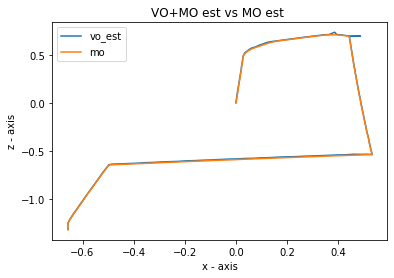

In [11]:
plt.plot(x,z,label="vo_est")
plt.plot(x_mo,z_mo,label="mo")
plt.title('VO+MO est vs MO est ')
plt.xlabel('x - axis')
plt.ylabel('z - axis')
plt.legend()
plt.show()

In [13]:
import random
from itertools import count
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.style.use('fivethirtyeight')

x_vals = []
y_vals = []

index = count()


def animate(i):
    data = pd.read_csv('data.csv')
    x = data['x_value']
    y1 = data['total_1']
    y2 = data['total_2']

    plt.cla()

    plt.plot(x, y1, label='Channel 1')
    plt.plot(x, y2, label='Channel 2')

    plt.legend(loc='upper left')
    plt.tight_layout()


ani = FuncAnimation(plt.gcf(), animate, interval=1000)

plt.tight_layout()
plt.show()

<Figure size 432x288 with 0 Axes>